IMPORTING THE NECESSARY LIBRARIES

In [30]:
# Importing core libraries for simulation, visualization, and saving outputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
import multiprocessing
from sklearn.preprocessing import MinMaxScaler

DATA GENERATION

In [31]:
# Setting reproducibility and visual style
np.random.seed(42)
sns.set(style="whitegrid")

# Creating folders to store EDA and result plots
os.makedirs("output/EDA", exist_ok=True)
os.makedirs("output/Results", exist_ok=True)


In [33]:
# Defining constants for simulation
NUM_NODES = 10
NUM_SOURCES = 3
HOURS = 24
PEAK_HOURS = list(range(17, 21))

# Defining labels for nodes and energy sources
node_labels = [f"Zone_{i+1}" for i in range(NUM_NODES)]
source_labels = ['Solar', 'Wind', 'Hydro']

# Generating time-dependent energy demand (more in evening hours)
hourly_factors = np.array([1.2 if h in PEAK_HOURS else 1.0 for h in range(HOURS)])
base_demand = np.tile(np.linspace(25, 60, HOURS), (NUM_NODES, 1)) * hourly_factors
demand_variation = np.random.normal(0, 5, base_demand.shape)
DEMAND = np.clip(base_demand + demand_variation, 20, 80).astype(int)

# Simulating energy supply limits per source
SUPPLY = np.array([1200, 1000, 1100])  # Solar, Wind, Hydro

# Generating transmission cost and loss matrices (Source x Node)
COST_MATRIX = np.round(np.random.uniform(0.1, 0.45, (NUM_SOURCES, NUM_NODES)), 2)
LOSS_MATRIX = np.round(np.random.uniform(0.01, 0.08, (NUM_SOURCES, NUM_NODES)), 3)

EDAS AND VISUALIZATIONS

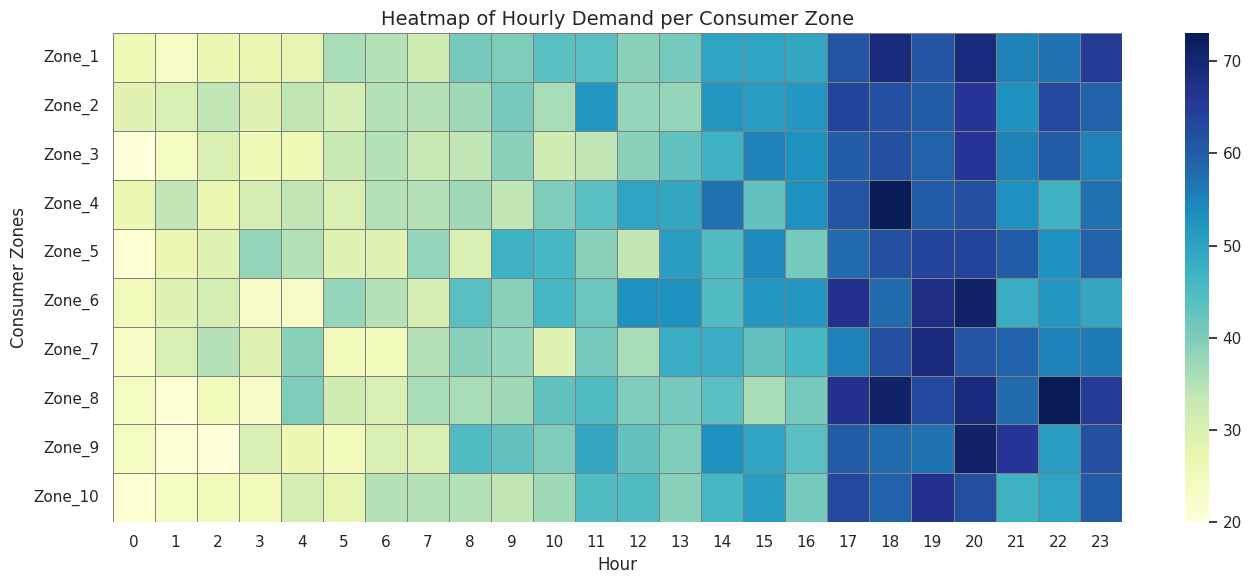

In [34]:
plt.figure(figsize=(14, 6))
sns.heatmap(DEMAND, cmap="YlGnBu", xticklabels=range(HOURS), yticklabels=node_labels, linewidths=0.5, linecolor='gray')
plt.title("Heatmap of Hourly Demand per Consumer Zone", fontsize=14)
plt.xlabel("Hour", fontsize=12)
plt.ylabel("Consumer Zones", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA1_Heatmap_Demand.png", dpi=300)
plt.show()


/tmp/ipython-input-35-515099008.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_labels, y=SUPPLY, palette="crest")


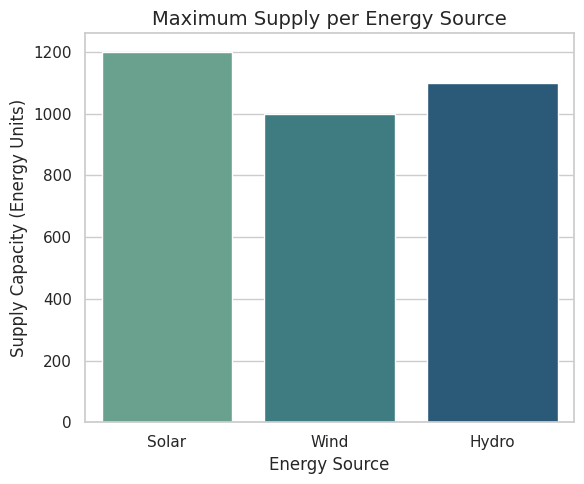

In [35]:
plt.figure(figsize=(6, 5))
sns.barplot(x=source_labels, y=SUPPLY, palette="crest")
plt.title("Maximum Supply per Energy Source", fontsize=14)
plt.ylabel("Supply Capacity (Energy Units)", fontsize=12)
plt.xlabel("Energy Source", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA2_Supply_Bar.png", dpi=300)
plt.show()


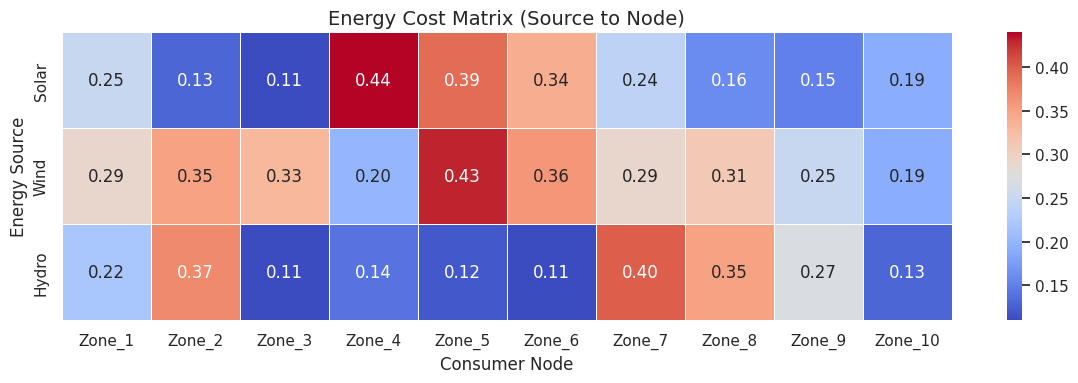

In [6]:
plt.figure(figsize=(12, 4))
sns.heatmap(COST_MATRIX, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=node_labels, yticklabels=source_labels, linewidths=0.5)
plt.title("Energy Cost Matrix (Source to Node)", fontsize=14)
plt.xlabel("Consumer Node", fontsize=12)
plt.ylabel("Energy Source", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA3_Cost_Matrix.png", dpi=300)
plt.show()


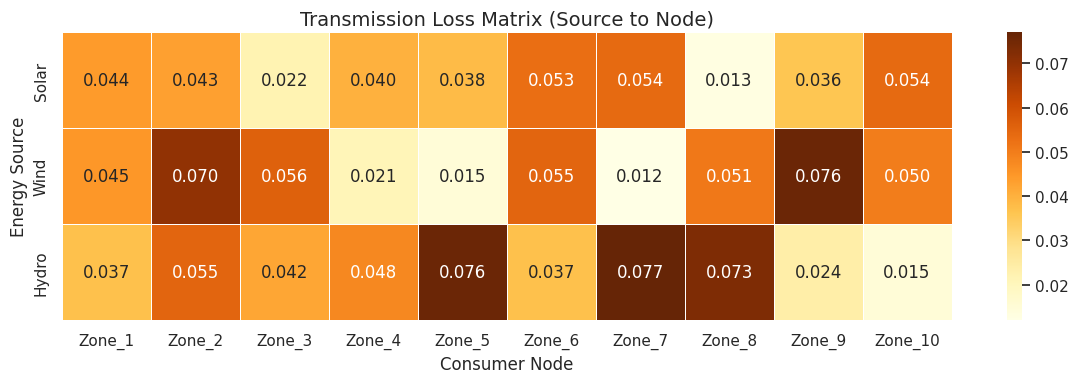

In [7]:
plt.figure(figsize=(12, 4))
sns.heatmap(LOSS_MATRIX, annot=True, fmt=".3f", cmap="YlOrBr", xticklabels=node_labels, yticklabels=source_labels, linewidths=0.5)
plt.title("Transmission Loss Matrix (Source to Node)", fontsize=14)
plt.xlabel("Consumer Node", fontsize=12)
plt.ylabel("Energy Source", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA4_Loss_Matrix.png", dpi=300)
plt.show()


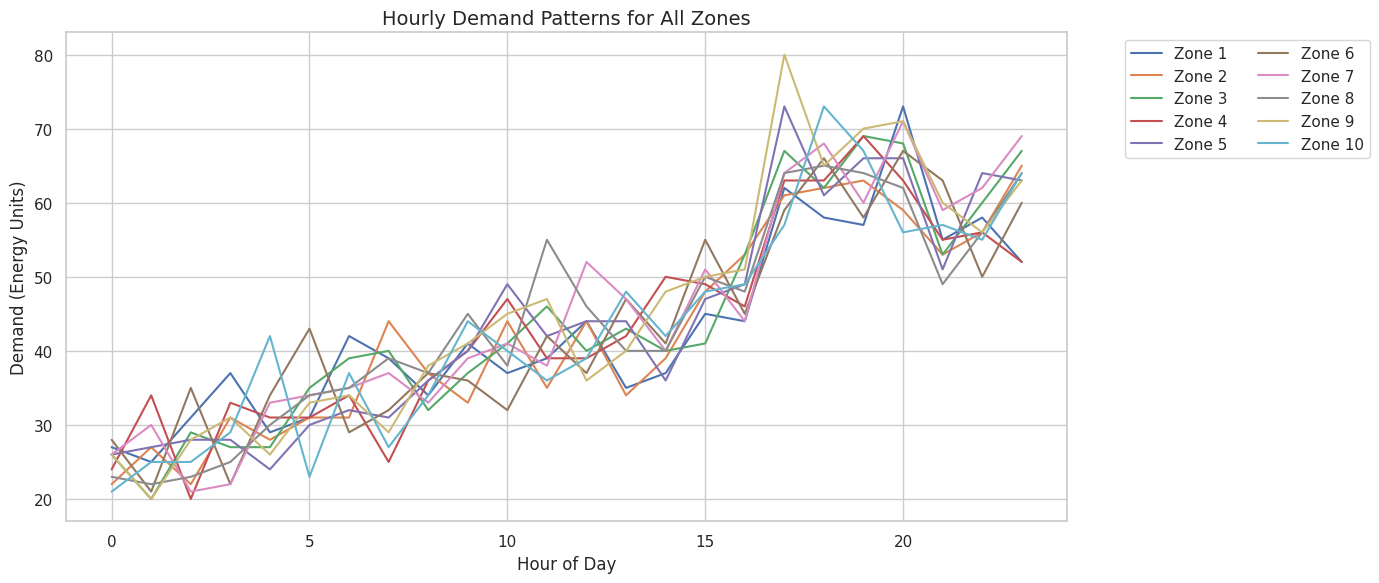

In [8]:
# Plotting hourly demand trends for all 10 consumer zones
plt.figure(figsize=(14, 6))

for i in range(NUM_NODES):
    plt.plot(range(HOURS), DEMAND[i], marker='', linestyle='-', label=f"Zone {i+1}")

plt.title("Hourly Demand Patterns for All Zones", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Demand (Energy Units)", fontsize=12)
plt.legend(ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("output/EDA/EDA5_AllZones_HourlyPatterns.png", dpi=300)
plt.show()


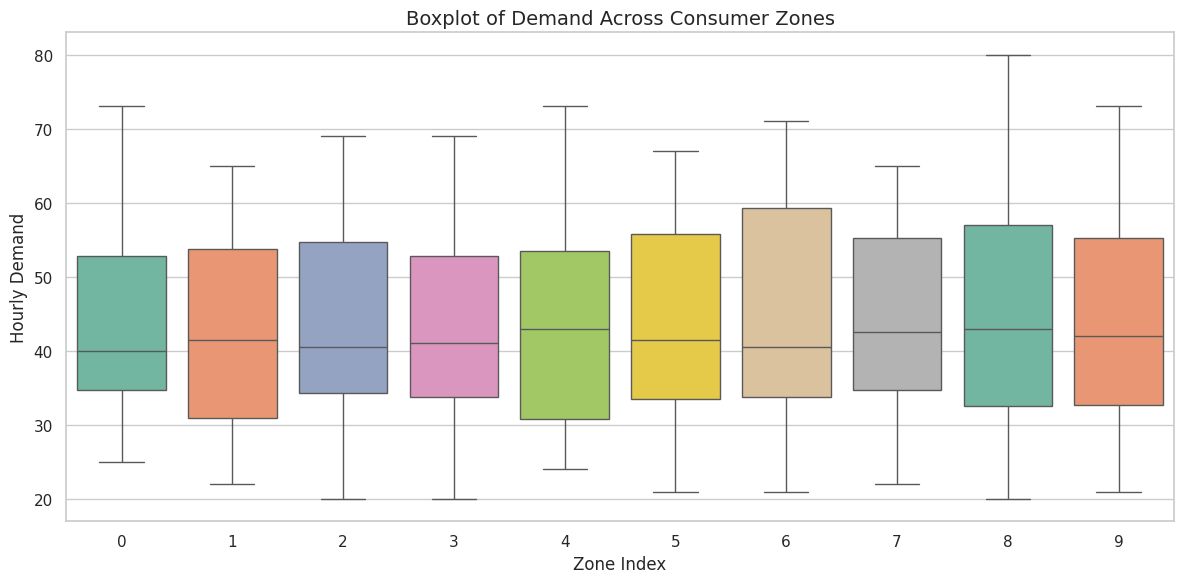

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=DEMAND.T, palette="Set2")
plt.title("Boxplot of Demand Across Consumer Zones", fontsize=14)
plt.xlabel("Zone Index", fontsize=12)
plt.ylabel("Hourly Demand", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA6_Boxplot_Demand.png", dpi=300)
plt.show()


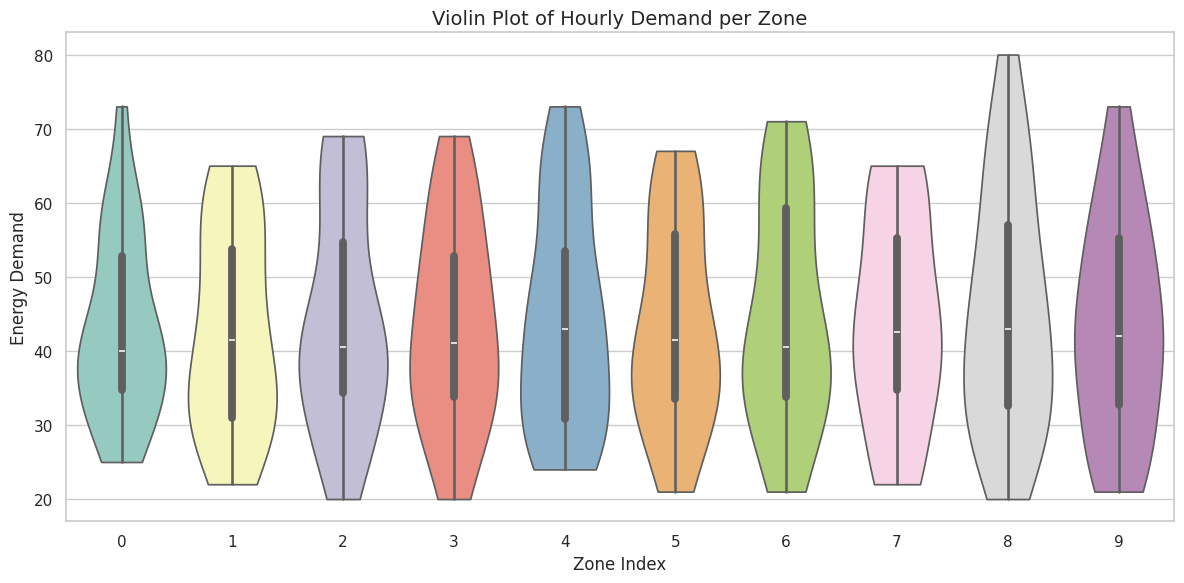

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=DEMAND.T, palette="Set3", cut=0)
plt.title("Violin Plot of Hourly Demand per Zone", fontsize=14)
plt.xlabel("Zone Index", fontsize=12)
plt.ylabel("Energy Demand", fontsize=12)
plt.tight_layout()
plt.savefig("output/EDA/EDA7_Violin_Demand.png", dpi=300)
plt.show()


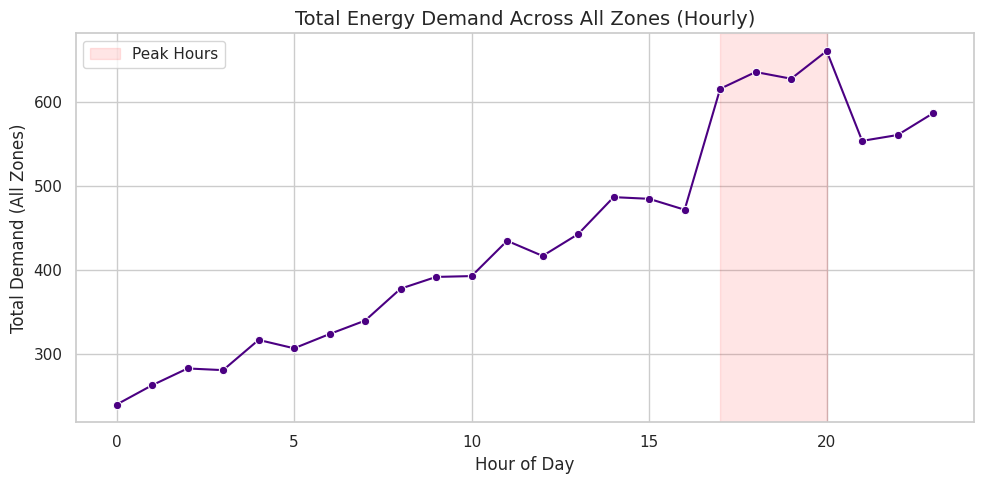

In [36]:
# Summing demand across all zones for each hour
total_demand_per_hour = DEMAND.sum(axis=0)

# Plotting the total demand trend over 24 hours
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(HOURS), y=total_demand_per_hour, marker='o', color='indigo')
plt.axvspan(17, 20, color='red', alpha=0.1, label="Peak Hours")
plt.title("Total Energy Demand Across All Zones (Hourly)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Total Demand (All Zones)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("output/EDA/EDA8_TotalDemand_Hourly.png", dpi=300)
plt.show()


DATA PREPROCESSING

In [37]:
# Checking if any NaN values exist in input matrices
print("Missing values in DEMAND:", np.isnan(DEMAND).sum())
print("Missing values in COST_MATRIX:", np.isnan(COST_MATRIX).sum())
print("Missing values in LOSS_MATRIX:", np.isnan(LOSS_MATRIX).sum())


Missing values in DEMAND: 0
Missing values in COST_MATRIX: 0
Missing values in LOSS_MATRIX: 0


SETTING UP GENETIC ALGORITHM

In [38]:
# Creating a chromosome by randomly generating allocation ratios
def encode_chromosome():
    return np.random.uniform(0, 1, (NUM_SOURCES, NUM_NODES, HOURS))


In [39]:
# Decoding the chromosome by scaling ratios to match demand
def decode_chromosome(chromosome):
    total_ratio = np.sum(chromosome, axis=0, keepdims=True) + 1e-6  # Preventing division by zero
    normalized = chromosome / total_ratio
    demand_scaled = normalized * DEMAND[np.newaxis, :, :]  # Broadcasting demand to match shape
    return demand_scaled


In [40]:
# Calculating the fitness score of a chromosome based on total cost, losses, and penalties
def fitness(chromosome):
    allocation = decode_chromosome(chromosome)

    # Summing total supply from each source
    total_supply_used = np.sum(allocation, axis=(1, 2))

    # Calculating total cost and total transmission loss
    cost = np.sum(COST_MATRIX[:, :, np.newaxis] * allocation)
    loss = np.sum(LOSS_MATRIX[:, :, np.newaxis] * allocation)

    # Penalizing overuse of source capacity
    overuse_penalty = np.sum(np.maximum(total_supply_used - SUPPLY, 0)) * 10

    # Penalizing unmet demand (in case float precision causes under-allocation)
    delivered = np.sum(allocation, axis=0)  # shape: (nodes, hours)
    unmet_demand = DEMAND - delivered
    unmet_demand[unmet_demand < 0] = 0  # Avoiding negative penalty
    unmet_penalty = np.sum(unmet_demand) * 5

    # Penalizing energy delivered during peak hours
    peak_usage = np.sum(allocation[:, :, PEAK_HOURS])
    peak_penalty = peak_usage * 0.05

    # Combining penalties and computing final fitness
    total_penalty = overuse_penalty + unmet_penalty + peak_penalty
    return -(cost + loss + total_penalty)  # Returning negative because GA maximizes fitness


In [41]:
# Performing crossover by blending two parents
def crossover(p1, p2):
    alpha = np.random.uniform(0.4, 0.6)
    return alpha * p1 + (1 - alpha) * p2


In [42]:
# Introducing small random changes into a chromosome
def mutate(chromosome, mutation_rate=0.05):
    mutation_mask = np.random.rand(*chromosome.shape) < mutation_rate
    chromosome[mutation_mask] = np.random.rand(*chromosome[mutation_mask].shape)
    return chromosome


SERIAL GENETIC ALGORITHM

In [49]:
# Running the full serial version of the genetic algorithm
def genetic_algorithm_serial(generations=50, population_size=30):
    # Generating initial population
    population = [encode_chromosome() for _ in range(population_size)]
    best_fitness_per_gen = []

    for gen in range(generations):
        # Evaluating each chromosome's fitness
        evaluated = [(chrom, fitness(chrom)) for chrom in population]
        evaluated.sort(key=lambda x: x[1], reverse=True)

        # Storing the best fitness score of the generation
        best_fitness_per_gen.append(evaluated[0][1])

        # Selecting top 50% as parents
        parents = [chrom for chrom, _ in evaluated[:population_size // 2]]
        next_gen = []

        # Creating new generation using crossover and mutation
        while len(next_gen) < population_size:
            p1, p2 = random.sample(parents, 2)
            child = crossover(p1, p2)
            child = mutate(child)
            next_gen.append(child)

        # Updating population for next generation
        population = next_gen

    # Returning the best solution and fitness scores per generation
    return evaluated[0][0], best_fitness_per_gen


In [50]:
# Timing the serial genetic algorithm
start_time = time.time()
best_chrom_serial, fitness_trend_serial = genetic_algorithm_serial(generations=50, population_size=30)
serial_runtime = time.time() - start_time

# Printing runtime and final fitness
print(f"Serial GA completed in {serial_runtime:.2f} seconds")
print(f"Best Fitness (Serial): {fitness_trend_serial[-1]:.4f}")


Serial GA completed in 0.15 seconds
Best Fitness (Serial): -75392.8520


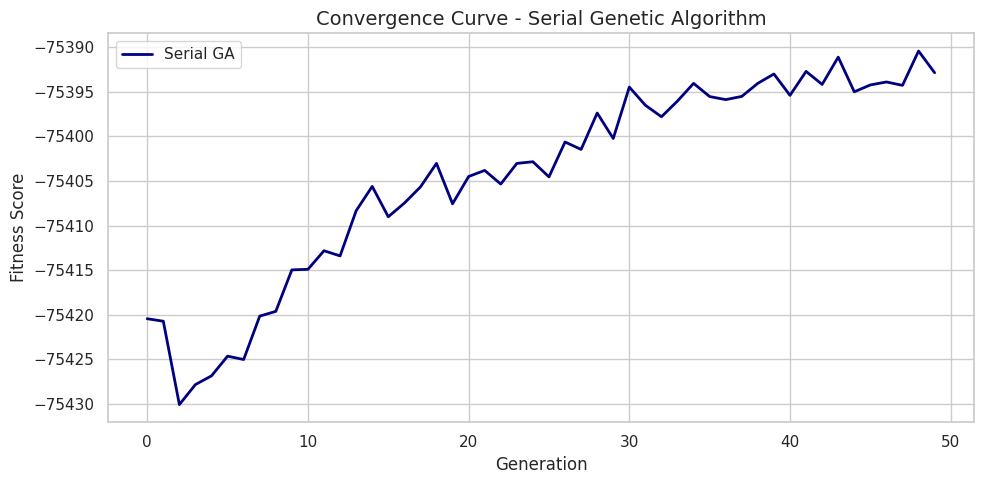

In [51]:
# Plotting the convergence of fitness score over generations
plt.figure(figsize=(10, 5))
plt.plot(fitness_trend_serial, label="Serial GA", color='navy', linewidth=2)
plt.title("Convergence Curve - Serial Genetic Algorithm", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("output/Results/Convergence_SerialGA.png", dpi=300)
plt.show()


PARALLEL GENETIC ALGORITHM

In [52]:
# Wrapper function for multiprocessing
def evaluate_fitness_parallel(chrom):
    return chrom, fitness(chrom)


In [53]:
# Wrapper function for multiprocessing
def evaluate_fitness_parallel(chrom):
    return chrom, fitness(chrom)


In [54]:
# Running the parallel version of the genetic algorithm
def genetic_algorithm_parallel(generations=50, population_size=30):
    # Initializing population
    population = [encode_chromosome() for _ in range(population_size)]
    best_fitness_per_gen = []

    # Creating a multiprocessing pool
    with multiprocessing.Pool() as pool:
        for gen in range(generations):
            # Evaluating population in parallel
            evaluated = pool.map(evaluate_fitness_parallel, population)

            # Sorting chromosomes by fitness (higher = better)
            evaluated.sort(key=lambda x: x[1], reverse=True)

            # Logging best fitness
            best_fitness_per_gen.append(evaluated[0][1])

            # Selecting top 50% as parents
            parents = [chrom for chrom, _ in evaluated[:population_size // 2]]
            next_gen = []

            # Creating children via crossover + mutation
            while len(next_gen) < population_size:
                p1, p2 = random.sample(parents, 2)
                child = crossover(p1, p2)
                child = mutate(child)
                next_gen.append(child)

            population = next_gen  # Updating population

    return evaluated[0][0], best_fitness_per_gen


In [55]:
# Running the parallel GA and timing it
start_time = time.time()
best_chrom_parallel, fitness_trend_parallel = genetic_algorithm_parallel(generations=50, population_size=30)
parallel_runtime = time.time() - start_time

# Printing results
print(f"Parallel GA completed in {parallel_runtime:.2f} seconds")
print(f"Best Fitness (Parallel): {fitness_trend_parallel[-1]:.4f}")


Parallel GA completed in 0.38 seconds
Best Fitness (Parallel): -75392.3054


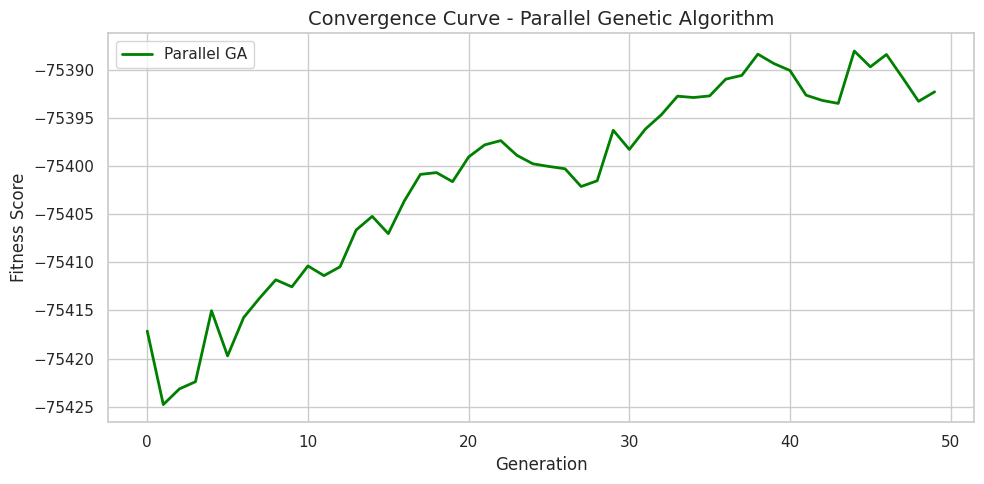

In [56]:
# Plotting convergence curve for parallel GA
plt.figure(figsize=(10, 5))
plt.plot(fitness_trend_parallel, label="Parallel GA", color='green', linewidth=2)
plt.title("Convergence Curve - Parallel Genetic Algorithm", fontsize=14)
plt.xlabel("Generation", fontsize=12)
plt.ylabel("Fitness Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("output/Results/Convergence_ParallelGA.png", dpi=300)
plt.show()


In [57]:
# Creating the comparison table
comparison_df = pd.DataFrame({
    'Technique': ['Serial GA'],
    'Best Fitness Score': [fitness_trend_serial[-1]],
    'Execution Time (s)': [serial_runtime]
})


In [58]:
# Creating a new row as DataFrame
new_row = pd.DataFrame({
    'Technique': ['Parallel GA'],
    'Best Fitness Score': [fitness_trend_parallel[-1]],
    'Execution Time (s)': [parallel_runtime]
})

# Concatenating safely
comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)


In [59]:
# Saving the updated comparison table
comparison_df.to_csv("output/Results/Comparison_Table.csv", index=False)

# Displaying for confirmation
display(comparison_df)


,Technique,Best Fitness Score,Execution Time (s)
0,Serial GA,-75392.852038,0.151960
1,Parallel GA,-75392.305425,0.383609


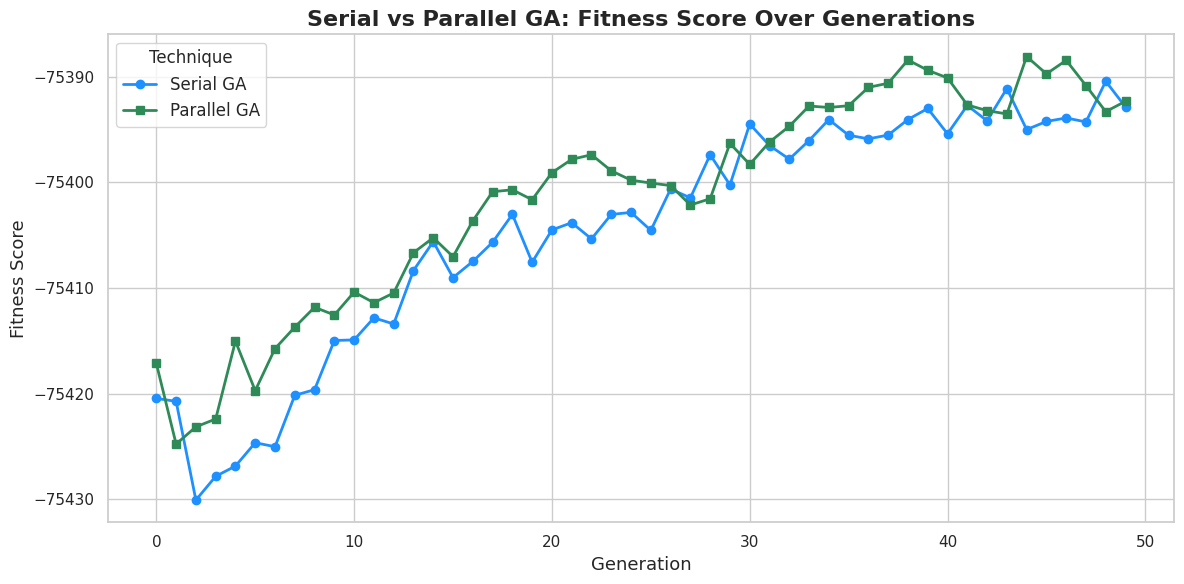

In [60]:
# Set visual style
sns.set(style='whitegrid')
plt.figure(figsize=(12, 6))

# Plot both GA trends
plt.plot(fitness_trend_serial, label='Serial GA', color='dodgerblue', marker='o', linewidth=2)
plt.plot(fitness_trend_parallel, label='Parallel GA', color='seagreen', marker='s', linewidth=2)

# Titles and labels
plt.title('Serial vs Parallel GA: Fitness Score Over Generations', fontsize=16, weight='bold')
plt.xlabel('Generation', fontsize=13)
plt.ylabel('Fitness Score', fontsize=13)
plt.legend(title='Technique', fontsize=12)
plt.tight_layout()
# Save the figure
plt.savefig("output/Results/Fitness_Trend_Comparison.png", dpi=300)
# Show plot
plt.show()


GREEDY HEURISTIC

In [61]:
# Applying greedy heuristic to allocate energy from sources to zones
def greedy_allocation():
    allocation = np.zeros((NUM_SOURCES, NUM_NODES, HOURS))
    supply_remaining = SUPPLY.copy()

    for h in range(HOURS):
        # Sorting demand at this hour (highest first)
        demand_at_h = DEMAND[:, h]
        demand_order = np.argsort(-demand_at_h)  # Descending order

        for node in demand_order:
            demand = DEMAND[node, h]
            for src in range(NUM_SOURCES):
                if supply_remaining[src] <= 0:
                    continue

                # Assign as much as possible
                delivered = min(demand, supply_remaining[src])
                allocation[src, node, h] += delivered
                supply_remaining[src] -= delivered
                demand -= delivered

                if demand <= 0:
                    break

    return allocation


In [62]:
# Scoring the greedy allocation manually using original fitness logic
def score_allocation(allocation):
    total_supply_used = np.sum(allocation, axis=(1, 2))
    cost = np.sum(COST_MATRIX[:, :, np.newaxis] * allocation)
    loss = np.sum(LOSS_MATRIX[:, :, np.newaxis] * allocation)

    overuse_penalty = np.sum(np.maximum(total_supply_used - SUPPLY, 0)) * 10

    delivered = np.sum(allocation, axis=0)
    unmet_demand = DEMAND - delivered
    unmet_demand[unmet_demand < 0] = 0
    unmet_penalty = np.sum(unmet_demand) * 5

    peak_usage = np.sum(allocation[:, :, PEAK_HOURS])
    peak_penalty = peak_usage * 0.05

    total_penalty = overuse_penalty + unmet_penalty + peak_penalty
    return -(cost + loss + total_penalty)


In [63]:
# Measuring high-resolution time for greedy allocation
start_time = time.perf_counter()
greedy_alloc = greedy_allocation()
greedy_runtime = time.perf_counter() - start_time

# Scoring the greedy allocation using the same cost + penalty function
greedy_fitness = score_allocation(greedy_alloc)

# Printing high-precision timing and result
print(f"Greedy Allocation completed in {greedy_runtime:.6f} seconds")
print(f"Fitness (Greedy): {greedy_fitness:.4f}")


Greedy Allocation completed in 0.001222 seconds
Fitness (Greedy): -37026.0180


COMPARISON TABLE

In [64]:
# Creating row for greedy results
greedy_row = pd.DataFrame({
    'Technique': ['Greedy Heuristic'],
    'Best Fitness Score': [greedy_fitness],
    'Execution Time (s)': [greedy_runtime]
})

# Appending to comparison table
comparison_df = pd.concat([comparison_df, greedy_row], ignore_index=True)
comparison_df.to_csv("output/Results/Comparison_Table.png", index=False)

# Display updated table
display(comparison_df)


,Technique,Best Fitness Score,Execution Time (s)
0,Serial GA,-75392.852038,0.151960
1,Parallel GA,-75392.305425,0.383609
2,Greedy Heuristic,-37026.018000,0.001222


COMPARISON PLOTS

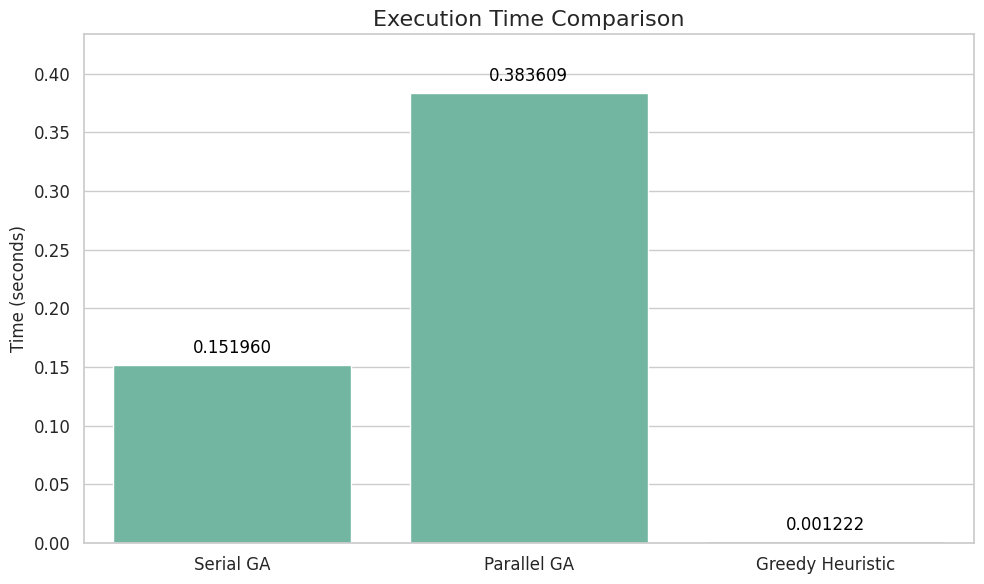

In [69]:
%matplotlib inline

# Set seaborn style
sns.set(style="whitegrid", palette="Set2")

# Final data
data = {
    "Technique": ["Serial GA", "Parallel GA", "Greedy Heuristic"],
    "Execution Time (s)": [0.151960, 0.383609 , 0.001222 ]
}
df = pd.DataFrame(data)

# Plot execution time
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Technique", y="Execution Time (s)", data=df)

# Annotate each bar
for index, row in df.iterrows():
    barplot.text(index, row["Execution Time (s)"] + 0.01,
                 f"{row['Execution Time (s)']:.6f}",
                 color='black', ha="center", fontsize=12)

plt.title("Execution Time Comparison", fontsize=16)
plt.ylabel("Time (seconds)")
plt.xlabel("")
plt.ylim(0, max(df["Execution Time (s)"]) + 0.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save and show
plt.savefig("output/Results/execution_time_comparison.png", dpi=300)
plt.show()


Testing mutation rates...
Testing mutation rate: 0.01
Average fitness: -75410.87 ± 4.80
Testing mutation rate: 0.03
Average fitness: -75402.61 ± 3.50
Testing mutation rate: 0.05
Average fitness: -75401.83 ± 0.67
Testing mutation rate: 0.07
Average fitness: -75402.88 ± 4.16
Testing mutation rate: 0.09
Average fitness: -75400.66 ± 5.40
Testing mutation rate: 0.11
Average fitness: -75405.48 ± 2.91
Testing mutation rate: 0.13
Average fitness: -75406.85 ± 3.82
Testing mutation rate: 0.15
Average fitness: -75410.01 ± 1.16
Testing mutation rate: 0.17
Average fitness: -75409.46 ± 3.84
Testing mutation rate: 0.19
Average fitness: -75414.19 ± 5.09


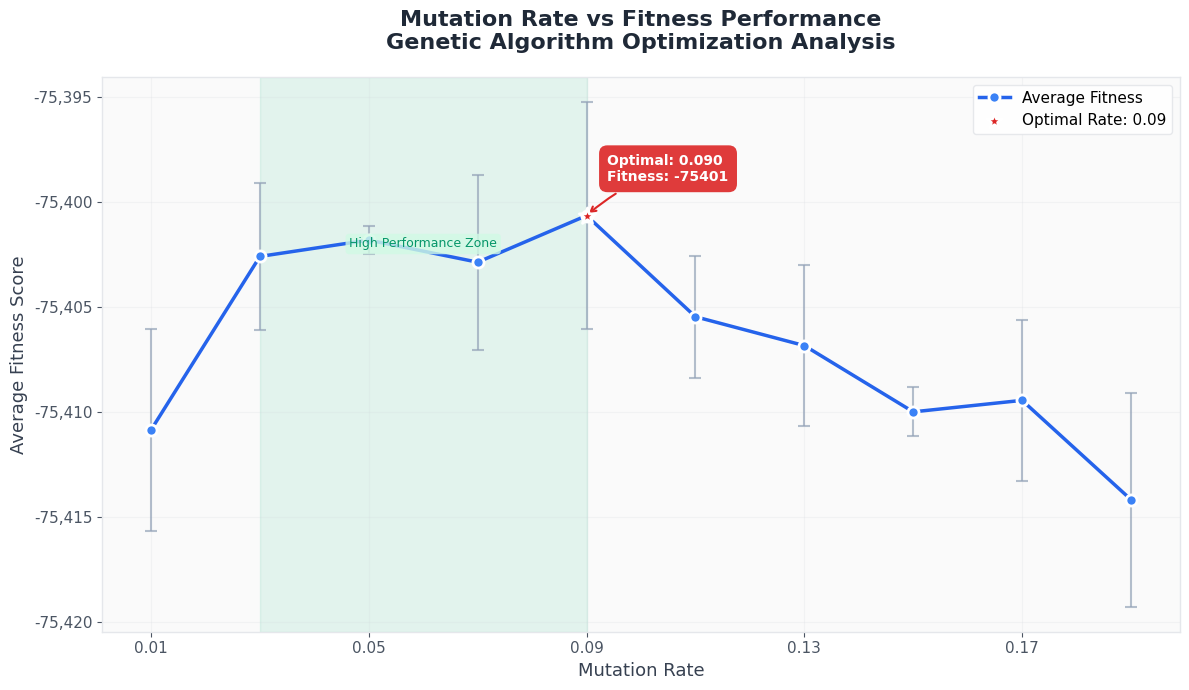


MUTATION RATE ANALYSIS SUMMARY
Optimal mutation rate: 0.090
Best average fitness: -75400.66
Fitness standard deviation: 5.40
Performance improvement: 13.53
Coefficient of variation: -0.0%
Recommended range: 0.030 - 0.090


In [70]:
# Testing different mutation rates using your existing GA function
def test_mutation_rates():
    mutation_rates = np.arange(0.01, 0.21, 0.02)  # 1% to 20% in 2% steps
    avg_fitness_scores = []
    std_fitness_scores = []

    print("Testing mutation rates...")

    for mut_rate in mutation_rates:
        print(f"Testing mutation rate: {mut_rate:.2f}")

        # Run GA 3 times with this mutation rate and average the results
        fitness_scores = []
        for trial in range(3):
            # Set different seed for each trial
            np.random.seed(42 + trial)
            random.seed(42 + trial)

            # Use your existing GA but modify mutation rate
            population = [encode_chromosome() for _ in range(20)]

            # Run for fewer generations since we're testing multiple rates
            for gen in range(25):
                evaluated = [(chrom, fitness(chrom)) for chrom in population]
                evaluated.sort(key=lambda x: x[1], reverse=True)

                parents = [chrom for chrom, _ in evaluated[:10]]
                next_gen = []

                while len(next_gen) < 20:
                    p1, p2 = random.sample(parents, 2)
                    child = crossover(p1, p2)
                    child = mutate(child, mut_rate)  # Use the test mutation rate
                    next_gen.append(child)

                population = next_gen

            # Get final best fitness
            final_evaluated = [(chrom, fitness(chrom)) for chrom in population]
            final_evaluated.sort(key=lambda x: x[1], reverse=True)
            fitness_scores.append(final_evaluated[0][1])

        # Calculate statistics
        avg_fitness = np.mean(fitness_scores)
        std_fitness = np.std(fitness_scores)
        avg_fitness_scores.append(avg_fitness)
        std_fitness_scores.append(std_fitness)
        print(f"Average fitness: {avg_fitness:.2f} ± {std_fitness:.2f}")

    return mutation_rates, avg_fitness_scores, std_fitness_scores

# Run the mutation rate test
mutation_rates, fitness_scores, std_scores = test_mutation_rates()

# Create clean, professional plot
plt.style.use('default')
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)
fig.patch.set_facecolor('white')

# Set clean background
ax.set_facecolor('#fafafa')

# Main line plot with error bars
line = ax.plot(mutation_rates, fitness_scores,
               color='#2563eb', linewidth=2.5, marker='o',
               markersize=8, markerfacecolor='#3b82f6',
               markeredgecolor='white', markeredgewidth=2,
               label='Average Fitness')

# Add error bars
ax.errorbar(mutation_rates, fitness_scores, yerr=std_scores,
           fmt='none', ecolor='#94a3b8', capsize=4, capthick=1.5,
           alpha=0.7, zorder=1)

# Find and highlight best point
best_idx = np.argmax(fitness_scores)
best_rate = mutation_rates[best_idx]
best_fitness = fitness_scores[best_idx]

# Highlight optimal point
ax.scatter(best_rate, best_fitness,
          color='#dc2626', s=150, marker='*',
          edgecolors='white', linewidth=2, zorder=5,
          label=f'Optimal Rate: {best_rate:.2f}')

# Clean annotation for best point
ax.annotate(f'Optimal: {best_rate:.3f}\nFitness: {best_fitness:.0f}',
           xy=(best_rate, best_fitness),
           xytext=(15, 25), textcoords='offset points',
           bbox=dict(boxstyle='round,pad=0.6', facecolor='#dc2626',
                    alpha=0.9, edgecolor='none'),
           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                          color='#dc2626', lw=1.5),
           fontsize=10, fontweight='600', color='white')

# Professional title and labels
ax.set_title('Mutation Rate vs Fitness Performance\nGenetic Algorithm Optimization Analysis',
            fontsize=16, fontweight='600', pad=20, color='#1f2937')

ax.set_xlabel('Mutation Rate', fontsize=13, fontweight='500', color='#374151')
ax.set_ylabel('Average Fitness Score', fontsize=13, fontweight='500', color='#374151')

# Format axes
ax.set_xticks(mutation_rates[::2])  # Show every other tick
ax.set_xticklabels([f'{rate:.2f}' for rate in mutation_rates[::2]], fontsize=11)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax.tick_params(axis='both', which='major', labelsize=11, colors='#4b5563')

# Clean grid
ax.grid(True, linestyle='-', alpha=0.2, color='#d1d5db', linewidth=0.8)
ax.set_axisbelow(True)

# Subtle borders
for spine in ax.spines.values():
    spine.set_edgecolor('#e5e7eb')
    spine.set_linewidth(1)

# Add legend
legend = ax.legend(loc='upper right', frameon=True,
                  fontsize=11, edgecolor='#e5e7eb')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)

# Add subtle performance indicator
fitness_range = max(fitness_scores) - min(fitness_scores)
performance_threshold = min(fitness_scores) + 0.8 * fitness_range

# Highlight high-performance region
high_perf_rates = [rate for rate, fitness in zip(mutation_rates, fitness_scores)
                   if fitness >= performance_threshold]
if high_perf_rates:
    ax.axvspan(min(high_perf_rates), max(high_perf_rates),
              alpha=0.1, color='#10b981', zorder=0)

    # Add text label for high performance zone
    ax.text(np.mean(high_perf_rates), max(fitness_scores) - 0.1 * fitness_range,
           'High Performance Zone',
           ha='center', va='center', fontsize=9,
           color='#059669', fontweight='500',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='#d1fae5',
                    edgecolor='none', alpha=0.8))

# Tight layout
plt.tight_layout()
plt.savefig("output/Results/mutation_rate_vs_fitness_professional.png",
           dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Clean summary output
print("\n" + "="*50)
print("MUTATION RATE ANALYSIS SUMMARY")
print("="*50)
print(f"Optimal mutation rate: {best_rate:.3f}")
print(f"Best average fitness: {best_fitness:.2f}")
print(f"Fitness standard deviation: {std_scores[best_idx]:.2f}")

# Calculate performance statistics
improvement = best_fitness - min(fitness_scores)
cv = np.std(fitness_scores) / np.mean(fitness_scores) * 100

print(f"Performance improvement: {improvement:.2f}")
print(f"Coefficient of variation: {cv:.1f}%")

# Recommend optimal range
top_performers = np.where(np.array(fitness_scores) >= performance_threshold)[0]
if len(top_performers) > 1:
    optimal_min = mutation_rates[top_performers[0]]
    optimal_max = mutation_rates[top_performers[-1]]
    print(f"Recommended range: {optimal_min:.3f} - {optimal_max:.3f}")
else:
    print(f"Recommended rate: {best_rate:.3f}")



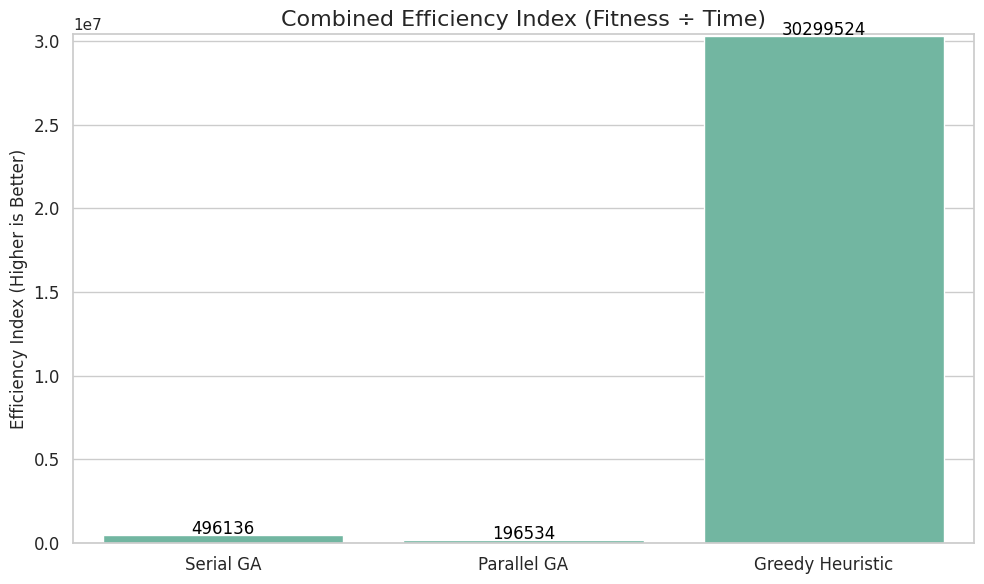

In [71]:
# Set style
sns.set(style="whitegrid", palette="Set2")

# Data
data = {
    "Technique": ["Serial GA", "Parallel GA", "Greedy Heuristic"],
    "Best Fitness Score": [-75392.852038, -75392.305425, -37026.018000],
    "Execution Time (s)": [0.151960, 0.383609, 0.001222]
}
df = pd.DataFrame(data)

# Calculate custom metric
df["Efficiency Index"] = df["Best Fitness Score"].abs() / df["Execution Time (s)"]

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Technique", y="Efficiency Index", data=df)

# Annotate
for index, row in df.iterrows():
    barplot.text(index, row["Efficiency Index"] + 50000,
                 f"{row['Efficiency Index']:.0f}",
                 color='black', ha="center", fontsize=12)

plt.title("Combined Efficiency Index (Fitness ÷ Time)", fontsize=16)
plt.ylabel("Efficiency Index (Higher is Better)", fontsize=12)
plt.xlabel("")
plt.ylim(0, max(df["Efficiency Index"]) + 100000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Save and show
plt.savefig("output/Results/efficiency_index_comparison.png", dpi=300)
plt.show()
